Copied from ``BEM_fit_nanrod_in_vacuum__012419-Copy1`` on 02/07/29


## 02/21/19
Going to remove parameter dependence of module `fitting_misLocalization.py` in order to have one notebook for drude and one for JC far-field fit results

In [1]:
from __future__ import print_function
from __future__ import division

import pdb
import sys
import os
import yaml

import numpy as np
import scipy.optimize as opt
from scipy import interpolate
import scipy.io as sio
import scipy.special as spf

## import diffrantion integral solver from Optics folder
project_path = ('/Users/chair/Documents/Academia/SuperRes/Biteen_colab/'
    +
    'Mispolarization/python/gitted'
    )
optics_path = project_path + '/Optics'
sys.path.append(optics_path)
# sys.path.append(date_dir)
import diffraction_int as diffi
import fibonacci as fib

## Read parameter file to obtain physical properties 
## of molecule and plasmon, molecule and imaging system.
parameter_files_path = (
    project_path + '/parameter_files'
)

curly_yaml_file_name = '/curly_nrod_water_JC.yaml'
parameters = yaml.load(open(parameter_files_path+curly_yaml_file_name,'r'))


modules_path = project_path + '/solving_problems/modules'
sys.path.append(modules_path)

import fitting_misLocalization as fit

## plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl
get_ipython().magic('matplotlib inline')
# mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rcParams['text.usetex'] = True

## colorbar stuff 
from mpl_toolkits import axes_grid1

## Import analytic expressions for the focused fields from a point dipole.
import anal_foc_diff_fields as afi

## Import computational solution to two coupled oscillators of arbitrarty 
## anisotropic polarizabilities. 
# import coupled_dipoles as cp 

## Import physical constants from yaml file.
phys_const_file_name = '/physical_constants.yaml'
opened_constant_file = open(
    parameter_files_path+phys_const_file_name,
    'r')
constants = yaml.load(opened_constant_file)
e = constants['physical_constants']['e']
c = constants['physical_constants']['c']  # charge of electron in statcoloumbs
hbar =constants['physical_constants']['hbar']
nm = constants['physical_constants']['nm']
n_a = constants['physical_constants']['nA']   # Avogadro's number
# Z_o = 376.7303 # impedence of free space in ohms (SI)

## Define some useful constants from defined parameters
n_b = parameters['general']['background_ref_index']
eps_b = n_b**2.
# a = parameters['plasmon']['radius']



#######################################################################
## Optics stuff.  
sensor_size = parameters['optics']['sensor_size']*nm
# height = 2*mm  # also defines objective lens focal length 
# height = parameters['optics']['obj_f_len']
resolution = parameters['optics']['sensor_pts']  # image grid resolution
## Build image sensor
eye = diffi.observation_points(
    x_min= -sensor_size/2, 
    x_max= sensor_size/2,
    y_min= -sensor_size/2, 
    y_max= sensor_size/2, 
    points= resolution
    )

## Experimental parameters
magnification = parameters['optics']['magnification']
numerical_aperture = parameters['optics']['numerical_aperture']
max_theta = np.arcsin(numerical_aperture) # defines physical aperture size

## numerical parameters for calculation of scattered field
lens_points = parameters['optics']['lens_points']

# obj_f = 1.*mm  # still dont know what this is supposed to be
obj_f = parameters['optics']['obj_f_len']

tube_f = magnification * obj_f

## calculate dipole magnitudes
drive_hbar_omega = parameters['general']['drive_energy'] ## rod long mode max at 1.8578957289256757 eV
omega_drive = drive_hbar_omega/hbar  # driving frequency

reading parameters from /Users/chair/Documents/Academia/SuperRes/Biteen_colab/Mispolarization/python/gitted/parameter_files/curly_nrod_water_JC.yaml
reading parameters from /Users/chair/Documents/Academia/SuperRes/Biteen_colab/Mispolarization/python/gitted/parameter_files/curly_nrod_water_JC.yaml
polarizability reduced by factor of 1
coupling scaled up by by factor of 1


##### setup warning tracker

In [2]:
import traceback
import warnings
import sys

def warn_with_traceback(message, category, filename, lineno, file=None, line=None):

    log = file if hasattr(file,'write') else sys.stderr
    traceback.print_stack(file=log)
    log.write(warnings.formatwarning(message, category, filename, lineno, line))

warnings.showwarning = warn_with_traceback

# initialize matlab stuff

In [3]:
## import matlab engine to run BEM
import matlab
import matlab.engine

variable_dict = {'list_of_coodinates':eye[0]/nm, 'meshed_X':eye[1]/nm,'meshed_Y':eye[2]/nm}


In [4]:
def fixed_ori_mol_placement(x_min=0, x_max=500, y_min=0, y_max=500, mol_grid_pts_1D = 3, mol_angle=0):
    locations = diffi.observation_points(x_min, x_max, y_min, y_max, points=mol_grid_pts_1D)[0]
    locations = np.hstack((locations,np.zeros((locations.shape[0],1))))
    
    mol_linspace_pts = mol_grid_pts_1D
#     random_mol_angles= (np.random.random(mol_linspace_pts**2)*np.pi*2)
    return [locations, mol_angle]

In [5]:
class Simulation(fit.DipoleProperties):
    """Runs BEM simulation
    
    Collects focused+diffracted far-field information from molecules nearby a nanorod 
    by MNPBEM calculation in an invisible instance of Matlab.
    
    Args:
        locations: list of 3D cartesien coordinates of molecules. 
            One simulation is run per location.  
        mol_angle: Angle on the molecule's dipole moment relatice to the x-axis
        plas_angle: Angle of the long-axis of the nanorod relative to the x-axis
    
    Attributes:
        mol_too_close: named confusingly, this method is built to filter locations
            for points within the fluorescence quenching region around the nanorod, 
            assigned to be 10 nm from the surface of the fit ellipsoid.
            Returns: VALID locations OUTSIDE this region.
        calculate_BEM_fields: runs simulatins and stores results in attributes; 
            bem_E: Focused and diffracted electric field
            BEM_images: 
    
    """
    
    ## set up inverse mapping from observed -> true angle for signle molecule in the plane. 
        
    def __init__(self, locations, mol_angle=0, plas_angle=np.pi/2
                 ):
        self.n_b = n_b ## vacuum
        self.mol_locations = locations
        self.mol_angles = mol_angle
        self.rod_angle = plas_angle
        
        #### Filtering out molecules in region of fluorescence quenching 
        self.el_a = self.a_long_meters/nm
        self.el_c = self.a_short_meters/nm
        self.quel_a = self.el_a + self.fluo_quench_range ## define quenching region
        self.quel_c = self.el_c + self.fluo_quench_range

        self.input_x_mol = locations[:,0]
        self.input_y_mol = locations[:,1]
        
        self.pt_is_in_ellip = self.mol_too_close()
        ## select molecules outside region,
        self.mol_locations = locations[self.pt_is_in_ellip]
        ## select molecule angles if listed per molecule, 
        if type(mol_angle)==np.ndarray and mol_angle.shape[0]>1:
            self.mol_angles = mol_angle[self.pt_is_in_ellip]
        else: self.mol_angles = mol_angle

        self.default_plot_limits = [
            np.min(self.mol_locations)-((np.max(self.mol_locations)-np.min(self.mol_locations))*.1),
            np.max(self.mol_locations)+((np.max(self.mol_locations)-np.min(self.mol_locations))*.1)]
        
        
    def mol_too_close(self):
        '''Returns molecule locations that are outside the fluorescence quenching zone,
            defined as 10 nm from surface of fit spheroid'''
        rotated_x = np.cos(self.rod_angle)*self.input_x_mol + np.sin(self.rod_angle)*self.input_y_mol
        rotated_y = -np.sin(self.rod_angle)*self.input_x_mol + np.cos(self.rod_angle)*self.input_y_mol
        long_quench_radius = self.quel_a
        short_quench_radius = self.quel_c
        rotated_ellip_eq = rotated_x**2./long_quench_radius**2 + rotated_y**2./short_quench_radius**2
        return (rotated_ellip_eq > 1)
        
    def calculate_BEM_fields(self):
        """ Runs BEM simulation in Matlab using parameters initialized parameters 
            """
        if hasattr(self, 'BEM_images'):
            return self.BEM_images
        
        ## start matlab before looping
        print('starting Matlab...')
        eng = matlab.engine.start_matlab()

        # Initialize coordinates of points on hemisphere for field BEM field 
        # calculation.
        sphere_points = fib.fib_alg_k_filter(
            num_points=lens_points, 
            max_ang=max_theta
            )
        # Convert spherical coordinates to Caresian.
        cart_points_on_sph = fib.sphere_to_cart(
            sphere_points[:,0],
            sphere_points[:,1],
            obj_f*np.ones(np.shape(sphere_points[:,0]))
            )
        
        ## convert lens-integration coordinates to matlab variable
        matlab_cart_points_on_sph = matlab.double(cart_points_on_sph.tolist())
        
        # Setup values for field calculation
        mol_locations = self.mol_locations
        mol_angle = self.mol_angles
        drive_energy = drive_hbar_omega
        
        number_of_molecules = mol_locations.shape[0]
        
        # Initialize outputs.
        self.BEM_images = np.zeros((number_of_molecules, eye[0].shape[0]))
        self.bem_E = np.zeros(
            (number_of_molecules, eye[0].shape[0], 3),
            dtype=np.complex_
            )
        
        # Loop through molecules and run BEM calculation in MATLAB
        for i in range(number_of_molecules):
            print('{}th molecule'.format(int(i+1)))
            mol_location = mol_locations[i]
            mol_orientation = [np.cos(mol_angle), np.sin(mol_angle), 0]

            # Run BEM calculation, return fields and coords.
            [E, sph_p] = eng.BEM_CurlyNanRod_dipDrive_E(
                matlab.double(list(mol_location)), 
                drive_energy, 
                matlab.double(list(mol_orientation)), 
                matlab_cart_points_on_sph,
                float(self.n_b**2.),
                nargout=2)
            
            # Format outputs for np
            BEM_scattered_E = np.asarray(E)
                # print('BEM_scattered_E.shape = ',BEM_scattered_E.shape)
                # BEM_scattered_H = np.asarray(H)
                # print('BEM_scattered_H.shape = ',BEM_scattered_H.shape)
            cart_sphere_points = np.asarray(sph_p)

            sph_sph_points = fib.cart_to_sphere(
                cart_sphere_points[:,0],
                cart_sphere_points[:,1],
                cart_sphere_points[:,2]
                ).T

            thetas_and_phis = sph_sph_points[:,1:]

            # Calculate focused+diffracted fields
            print('calculating diffracted fields')            
            diffracted_E_field = diffi.perform_integral(
                scattered_E=BEM_scattered_E, 
                scattered_sph_coords=thetas_and_phis, 
                obser_pts=eye[0]*np.array([[1,-1]]), 
                z=0, 
                obj_f=obj_f, 
                tube_f=tube_f, 
                k=omega_drive*self.n_b/c,
                alpha_1_max=max_theta
                )

            diffracted_power_flux = np.real(
                np.sum(
                    np.multiply(diffracted_E_field,
                        np.conj(diffracted_E_field)
                        ),
                    axis=-1
                    )
                )

            self.bem_E[i] = diffracted_E_field
            self.BEM_images[i] = diffracted_power_flux
        return self.BEM_images

### Wrap Simulation class into an object with same attributes as MolCoupNanoRodExp, so that the Gaussian Localization can be calculated

In [6]:
class SimulatedExperiment(Simulation,fit.MolCoupNanoRodExp):        
    """ Give BEM simulation class instance same attributes as Model Exp class for easy plotting.
        """
    def __init__(self, locations, mol_angle=0, plas_angle=np.pi/2, 
                 obs_points=None,):
        
        fit.CoupledDipoles.__init__(self, obs_points)
        
        Simulation.__init__(self, locations, mol_angle, plas_angle)
        
    def plot_mispol_map_wMisloc(self, plot_limits=None, given_ax=None,):
        return fit.MolCoupNanoRodExp.plot_mispol_map_wMisloc(
            self,
            plot_limits=plot_limits,
            given_ax=given_ax,
            plot_ellipse=False,
            )
        

In [7]:
# locations, angles = fixed_ori_mol_placement(mol_grid_pts_1D=5, x_max=300, y_max=300)
# simTestInst_few_mol = SimulatedExperiment(locations, mol_angle=np.pi/2)
# simTestInst_few_mol.trial_images = simTestInst_few_mol.calculate_BEM_fields()

In [8]:
# simTestInst_few_mol.plot_mispol_map_wMisloc()

### model fit

In [9]:
# ## Fit naively without knowing true location. 
# naive_fit_BEM_instance = fit.FitModelToData(
#     simTestInst_few_mol.BEM_images, 
# #     ini_guess=simTestInst_few_mol.mol_locations
#     )
# naive_fit_BEM_instance.fit_model_to_image_data()

# naive_fit_BEM_instance.plot_fit_results_as_quiver_map(simTestInst_few_mol)   

In [10]:
# ## Fit smartly, knowing true location. 
# smart_fit_BEM_instance = fit.FitModelToData(
#     simTestInst_few_mol.BEM_images, 
#     ini_guess=simTestInst_few_mol.mol_locations
#     )
# smart_fit_BEM_instance.fit_model_to_image_data()


In [11]:
# smart_fit_BEM_instance.plot_fit_results_as_quiver_map(simTestInst_few_mol)   

Great, seems to be working, let's do the x oriented molecules

In [12]:
# ## Run simulations and run Gaussian localization fits and average polarization

# # locations, angles = fixed_ori_mol_placement(mol_grid_pts_1D=5, x_max=300, y_max=300)
# sim_exp_inst_x = SimulatedExperiment(locations, mol_angle=0)
# sim_exp_inst_x.trial_images = sim_exp_inst_x.calculate_BEM_fields()

# ## Plot
# sim_exp_inst_x.plot_mispol_map_wMisloc()

In [13]:
# ## Fit model to simulated images. 

# naive_BEM_fit_instance_x = fit.FitModelToData(
#     sim_exp_inst_x.BEM_images, 
# #     ini_guess=sim_exp_inst_x.mol_locations
#     )
# naive_BEM_fit_instance_x.fit_model_to_image_data()

# ## Plot
# naive_BEM_fit_instance_x.plot_fit_results_as_quiver_map(sim_exp_inst_x)   

In [14]:
# ## Fit model to simulated images. 

# smart_BEM_fit_instance_x = fit.FitModelToData(
#     sim_exp_inst_x.BEM_images, 
#     ini_guess=sim_exp_inst_x.mol_locations
#     )
# smart_BEM_fit_instance_x.fit_model_to_image_data()

# ## Plot
# smart_BEM_fit_instance_x.plot_fit_results_as_quiver_map(sim_exp_inst_x)   

### Next up are the closer locations...



In [15]:
# locations, angles = fixed_ori_mol_placement(mol_grid_pts_1D=3, x_max=75, y_max=75)
# simTestInst_few_mol = SimulatedExperiment(locations, mol_angle=np.pi/2)
# simTestInst_few_mol.trial_images = simTestInst_few_mol.calculate_BEM_fields()
# # Plot
# simTestInst_few_mol.plot_mispol_map_wMisloc()

# # ## Initial guess defaults to position of maximum intensity. 
# # test_BEM_fit_instance_few_mol = fit.FitModelToData(
# #     simTestInst_few_mol.BEM_images, 
# # #     ini_guess=simTestInst_few_mol.mol_locations
# #     )
# # test_BEM_fit_few_mol = test_BEM_fit_instance_few_mol.fit_model_to_image_data()

# # ## Plot fit results
# # test_BEM_fit_instance_few_mol.plot_fit_results_as_quiver_map(simTestInst_few_mol)   

### Try to save neccesary data for next plot

In [98]:
def save_sim_exp_inst(sim_exp_instance, data_dir_name):
    path_to_data = (
        "/Users/chair/Documents/Academia/SuperRes/Biteen_colab/"
        +
        "Mispolarization/python/gitted/solving_problems/data/"
        +
        data_dir_name
        )
    os.mkdir( path_to_data )
#     print(path_to_data+'/BEM_images.txt')
    np.savetxt(path_to_data+'/BEM_images.txt',sim_exp_instance.BEM_images)
    np.savetxt(path_to_data+'/mol_locations.txt',sim_exp_instance.mol_locations)
    np.savetxt(path_to_data+'/default_plot_limits.txt',sim_exp_instance.default_plot_limits)
    np.savetxt(path_to_data+'/mol_angles.txt',np.atleast_1d(sim_exp_instance.mol_angles))
    np.savetxt(path_to_data+'/rod_angle.txt',np.atleast_1d(sim_exp_instance.rod_angle))
    np.savetxt(path_to_data+'/obs_points[0].txt',np.atleast_1d(sim_exp_instance.obs_points[0]))
    np.savetxt(path_to_data+'/obs_points[1].txt',np.atleast_1d(sim_exp_instance.obs_points[1]))
    np.savetxt(path_to_data+'/obs_points[2].txt',np.atleast_1d(sim_exp_instance.obs_points[2]))

In [100]:
save_sim_exp_inst(simTestInst_few_mol_h_100,'test3')

In [107]:
type(simTestInst_few_mol_h_100.obs_points)

numpy.ndarray

In [135]:
class LoadedSimExp(SimulatedExperiment):
    
    def __init__(self, 
        data_dir_name
                ):
        
        self.path_to_data = (
            "/Users/chair/Documents/Academia/SuperRes/Biteen_colab/"
            +
            "Mispolarization/python/gitted/solving_problems/data/"
            +
            data_dir_name
            )


        self.BEM_images = np.loadtxt(self.path_to_data+'/BEM_images.txt')
        self.trial_images = np.loadtxt(self.path_to_data+'/BEM_images.txt')
        self.mol_locations = np.loadtxt(self.path_to_data+'/mol_locations.txt')
        self.default_plot_limits = np.loadtxt(self.path_to_data+'/default_plot_limits.txt')
        self.mol_angles = np.loadtxt(self.path_to_data+'/mol_angles.txt')
        self.rod_angle = np.atleast_1d(np.loadtxt(self.path_to_data+'/rod_angle.txt'))[0]
        
        obs_points_0 = np.loadtxt(self.path_to_data+'/obs_points[0].txt')
        obs_points_1 = np.loadtxt(self.path_to_data+'/obs_points[1].txt')
        obs_points_2 = np.loadtxt(self.path_to_data+'/obs_points[2].txt')
        
        self.obs_points = np.array([obs_points_0, obs_points_1, obs_points_2])


In [136]:
loaded_inst = LoadedSimExp('test3')

In [138]:
loaded_inst.rod_angle

1.5707963267948966

In [139]:
loaded_inst.plot_mispol_map_wMisloc()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

### Initial guess checker

In [19]:
# ## Initial guess defaults to position of maximum intensity. 
# test_BEM_fit_instance_few_mol = fit.FitModelToData(
#     loaded_inst.BEM_images, 
# #     ini_guess=loaded_inst.mol_locations
    
#     )

# # New initial guess checker
# test_BEM_fit_few_mol = test_BEM_fit_instance_few_mol.fit_model_to_image_data(
# #     check_ini=False
#     )

# ## Plot fit results
# # Uses plotlimits, 2 angles, and mol locations from simInst for plot. 
# test_BEM_fit_instance_few_mol.plot_fit_results_as_quiver_map(loaded_inst)   

Testing paper plot

In [20]:
# cbar_width = 0.15
# plot_width = 4
# widths = [cbar_width, plot_width, plot_width, cbar_width]
# heights = [1]
# gs_kw = dict(width_ratios=widths, height_ratios=heights)

# paper_fig, paper_axs = plt.subplots(
#     nrows=1, 
#     ncols=4, 
# #     sharey=True, 
#     figsize=(6.5, 3), 
#     dpi=300, 
#     constrained_layout=True,
#     gridspec_kw=gs_kw
#     )

# left_ax = simTestInst_few_mol.plot_mispol_map_wMisloc(given_ax=paper_axs.flatten()[1]) 
# left_ax.yaxis.tick_right()
# left_ax.yaxis.set_label_position("right")
# left_ax.set_title(None)

# right_ax = test_BEM_fit_instance_few_mol.plot_fit_results_as_quiver_map(simTestInst_few_mol, given_ax=paper_axs.flatten()[2])  
# right_ax.set_ylabel(None)
# right_ax.yaxis.set_ticklabels([None])
# right_ax.set_title(None)

# test_BEM_fit_instance_few_mol.build_colorbar(
#     paper_axs.flatten()[3],
#     'Molecule angle from best model fit [deg]',
#     fit.PlottingStuff.curlycm
#     )

# test_BEM_fit_instance_few_mol.build_colorbar(
#     paper_axs.flatten()[0],
#     'PBD polarization angle [deg]',
#     fit.PlottingStuff.curlycm
#     )

# paper_axs.flatten()[0].yaxis.tick_left()
# paper_axs.flatten()[0].yaxis.set_label_position("left")

In [21]:
# ## Initial guess defaults to position of maximum intensity. 
# test_BEM_fit_instance_few_mol = fit.FitModelToData(
#     loaded_inst.BEM_images, 
# #     ini_guess=loaded_inst.mol_locations
#     )

# # New initial guess checker
# test_BEM_fit_few_mol = test_BEM_fit_instance_few_mol.fit_model_to_image_data(
#     check_ini=True
#     )

# ## Plot fit results
# # Uses plotlimits, 2 angles, and mol locations from simInst for plot. 
# test_BEM_fit_instance_few_mol.plot_fit_results_as_quiver_map(loaded_inst)   

### try with Gaussian initial guess

In [22]:
# ## Initial guess defaults to position of maximum intensity. 
# test_BEM_fit_instance_few_mol = fit.FitModelToData(
#     loaded_inst.BEM_images, 
# #     ini_guess=loaded_inst.mol_locations,
#     ini_guess='gauss',
#     )

# # New initial guess checker
# test_BEM_fit_few_mol = test_BEM_fit_instance_few_mol.fit_model_to_image_data(
#     check_ini=True,
#     )

# ## Plot fit results
# # Uses plotlimits, 2 angles, and mol locations from simInst for plot. 
# test_BEM_fit_instance_few_mol.plot_fit_results_as_quiver_map(loaded_inst)   

In [23]:
# # Build composite plot comparing gaussian&PBS to model

# comp_fig, axes = plt.subplots(1,2, dpi=600)

# curly_mod_inst_transRes_xMol.plot_mispol_map(given_ax=axes[0])
# curly_mod_inst_transRes_xMol_isoTrans.plot_mispol_map(given_ax=axes[1])

# for i in range(2):
#     for j in range(3):
#         axes[i,j].yaxis.tick_right()
#         axes[i,j].yaxis.set_label_position("right")
#         axes[i,j].set(title=None)
#         if (i == 0) or (i == 1 and j != 2):            
#             axes[i,j].set(
#                 xticklabels=[None],yticklabels=[None],
#                 xlabel=None,ylabel=None
#                 )

# plt.tight_layout()

## Figure 5 in mispol paper

starting Matlab...
given even number of points for Fibonacci lattice, 
  adding 1...
1th molecule
calculating diffracted fields
2th molecule
calculating diffracted fields
3th molecule
calculating diffracted fields
4th molecule
calculating diffracted fields
5th molecule
calculating diffracted fields
6th molecule
calculating diffracted fields
7th molecule
calculating diffracted fields
8th molecule
calculating diffracted fields
9th molecule
calculating diffracted fields
10th molecule
calculating diffracted fields
11th molecule
calculating diffracted fields
12th molecule
calculating diffracted fields
13th molecule
calculating diffracted fields
14th molecule
calculating diffracted fields
15th molecule
calculating diffracted fields
16th molecule
calculating diffracted fields
17th molecule
calculating diffracted fields
18th molecule
calculating diffracted fields
19th molecule
calculating diffracted fields
20th molecule
calculating diffracted fields
21th molecule
calculating diffracted fields


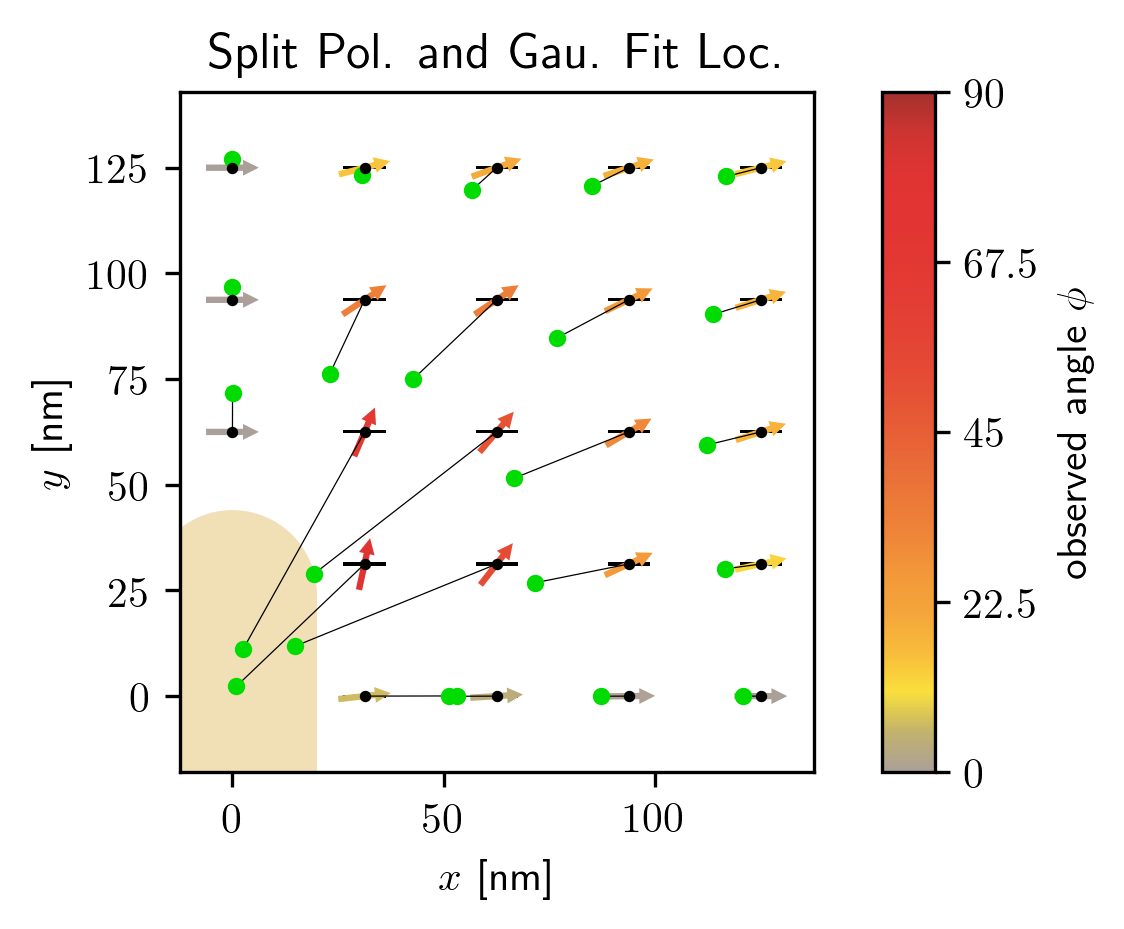

In [24]:
locations_100, angles_100 = fixed_ori_mol_placement(mol_grid_pts_1D=5, x_max=125, y_max=125)
simTestInst_few_mol_h_100 = SimulatedExperiment(locations_100, mol_angle=0)
simTestInst_few_mol_h_100.trial_images = simTestInst_few_mol_h_100.calculate_BEM_fields()

simTestInst_few_mol_h_100.plot_mispol_map_wMisloc()


 initial guess for molecule 0 location: (0.024364324852450908,71.69308926126834)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  0.024364324852450908 
 ini_y,  71.69308926126834 
 self.quel_a,  61.77701186 
 self.quel_c,  25.96014311 

In quenching zone? False

 initial guess for molecule 1 location: (0.010346667188950434,96.76896818489736)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  0.010346667188950434 
 ini_y,  96.76896818489736 
 self.quel_a,  61.77701186 
 self.quel_c,  25.96014311 

In quenching zone? False

 initial guess for molecule 2 location: (0.008965912824922692,127.15093337361)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  0.008965912824922692 
 ini_y,  127.15093337361 
 self.quel_a,  61.77701186 
 self.quel_c,  25.96014311 

In quenching zone? False

 initial guess for molecule 3 location: (51.11939425172493,0.03662429875275257)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  51.119394

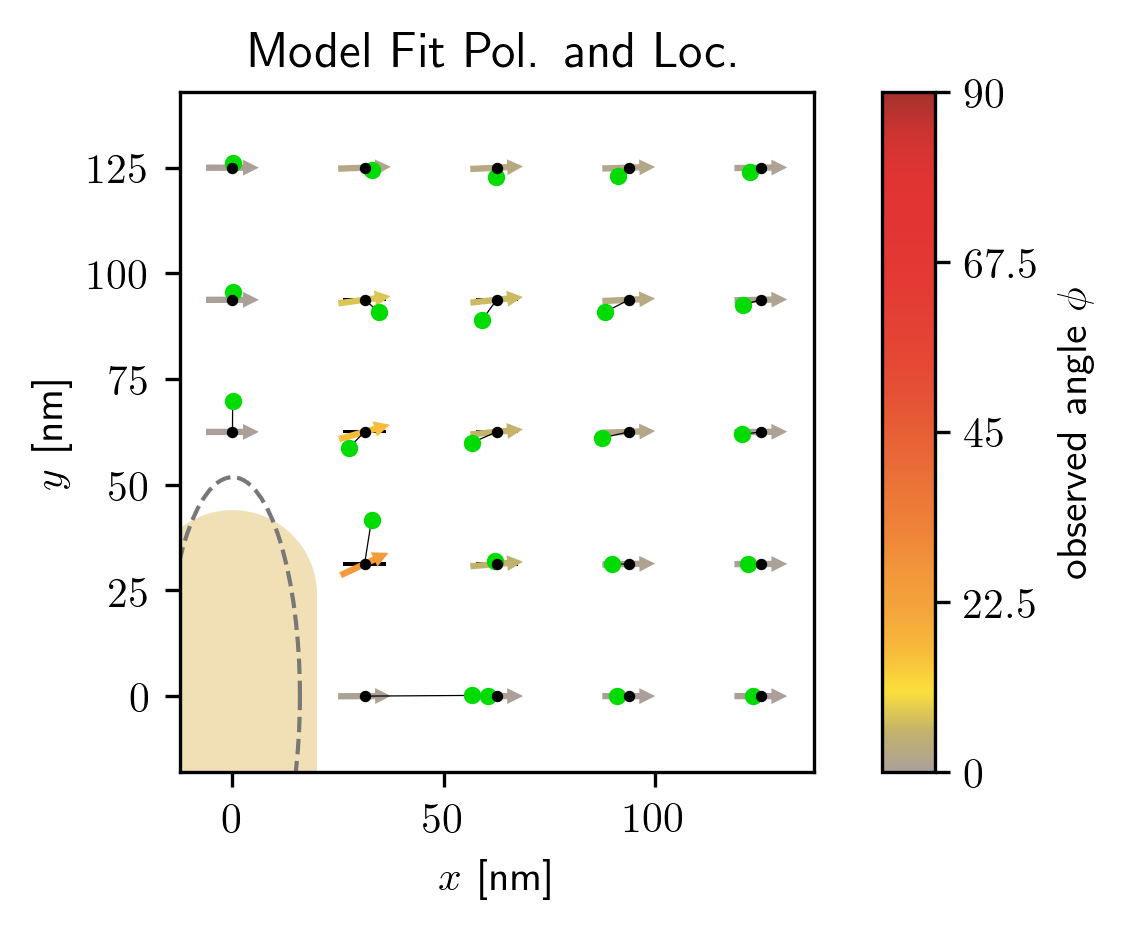

In [25]:
# Model fit
# Gaussian guess, checked

test_BEM_fit_instance_few_mol_h_100 = fit.FitModelToData(
    simTestInst_few_mol_h_100.BEM_images, 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss'
    )
test_BEM_fit_few_mol_h_100 = test_BEM_fit_instance_few_mol_h_100.fit_model_to_image_data(
    check_ini=True)

## Plot fit results
test_BEM_fit_instance_few_mol_h_100.plot_fit_results_as_quiver_map(simTestInst_few_mol_h_100)   

In [153]:
range(0,90,10)

range(0, 90, 10)

[Text(0, 0, '')]

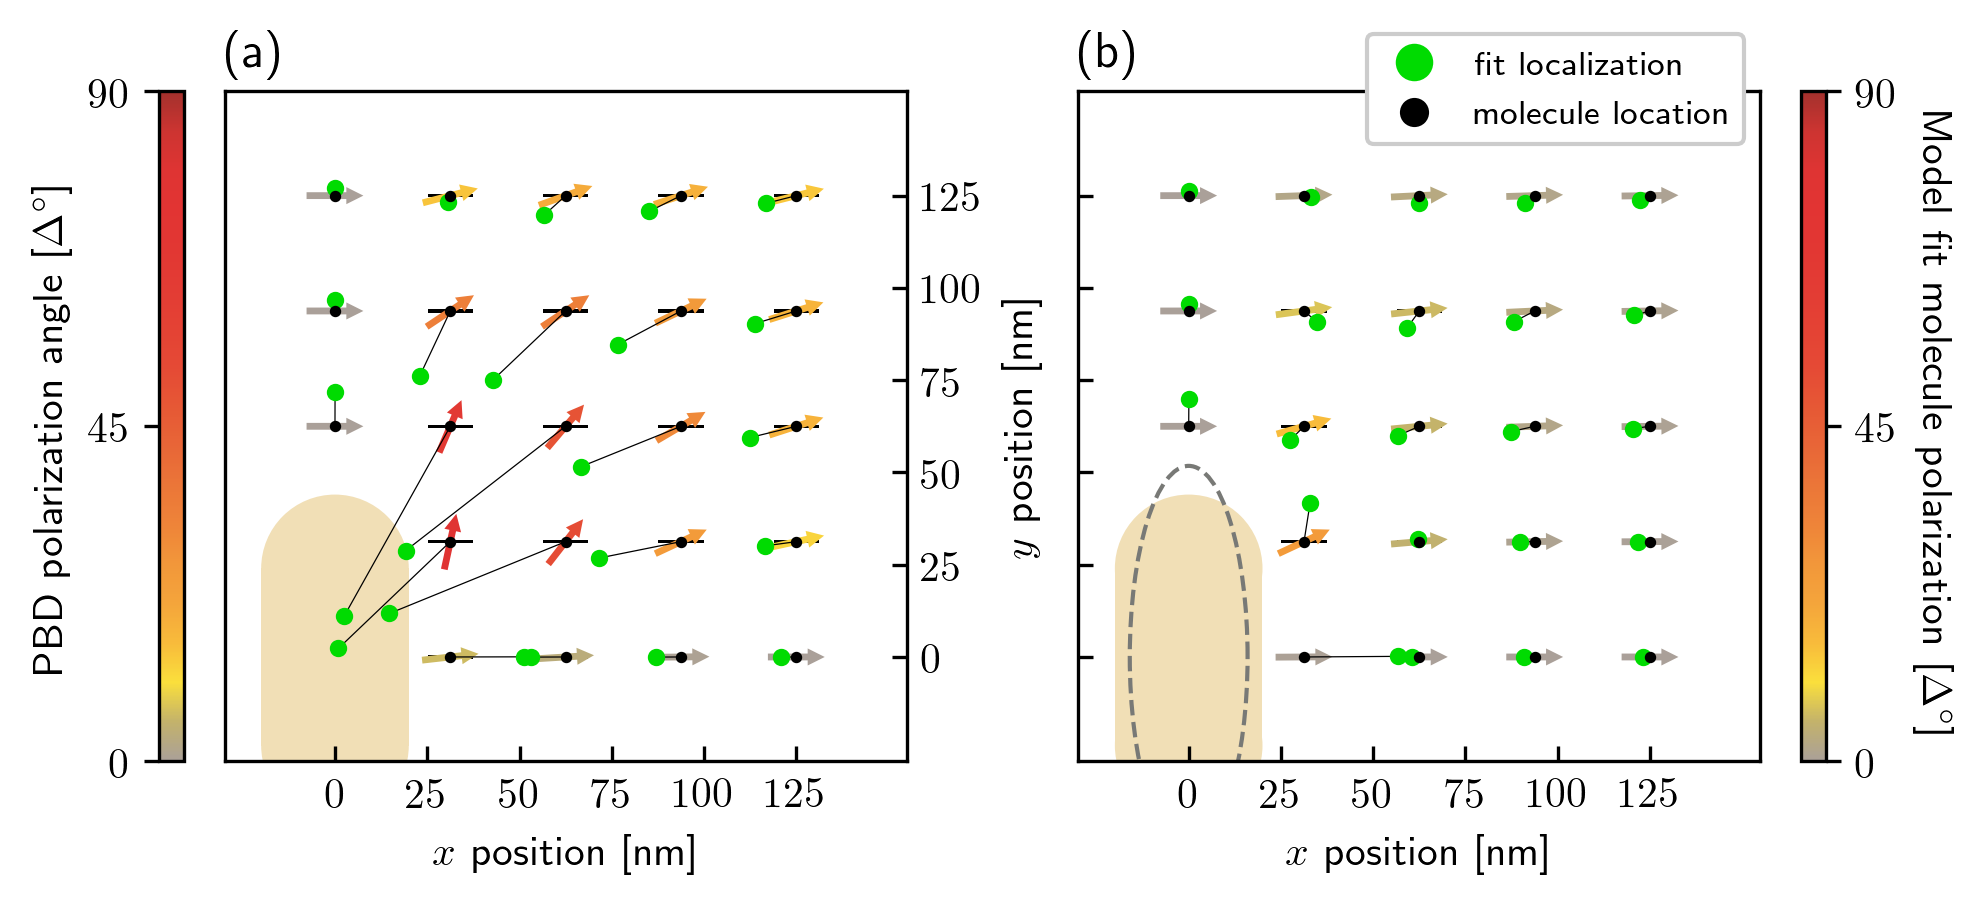

In [188]:
cbar_width = 0.15
plot_width = 4
widths = [cbar_width, plot_width, plot_width, cbar_width]
heights = [1]
gs_kw = dict(width_ratios=widths, height_ratios=heights)

paper_fig, paper_axs = plt.subplots(
    nrows=1, 
    ncols=4, 
#     sharey=True, 
    figsize=(6.5, 2.9), 
    dpi=300, 
    constrained_layout=True,
    gridspec_kw=gs_kw
    )

left_ax = simTestInst_few_mol_h_100.plot_mispol_map_wMisloc(given_ax=paper_axs.flatten()[1]) 
left_ax.yaxis.tick_right()
left_ax.yaxis.set_label_position("right")
# left_ax.set_title(None)

right_ax = test_BEM_fit_instance_few_mol_h_100.plot_fit_results_as_quiver_map(simTestInst_few_mol_h_100, given_ax=paper_axs.flatten()[2])  
# right_ax.set_title(None)

test_BEM_fit_instance_few_mol_h_100.build_colorbar(
    paper_axs.flatten()[0],
    r'PBD polarization angle [$\Delta^\circ$]',
    fit.PlottingStuff.curlycm
    )

test_BEM_fit_instance_few_mol_h_100.build_colorbar(
    paper_axs.flatten()[3],
    'Molecule angle by model fit [deg]',
    fit.PlottingStuff.curlycm
    )

paper_axs.flatten()[0].yaxis.tick_left()
paper_axs.flatten()[0].yaxis.set_label_position("left")

# Legends
def loc_map_legend(ax, loc_label='fit localization'):
    legend_elements = [
        mpl.lines.Line2D(
            [0], [0], 
            marker='o', 
            color='w', 
            label=loc_label,
            markerfacecolor=fit.PlottingStuff.a_shade_of_green, 
            markersize=10
            ),
        mpl.lines.Line2D(
            [0], [0], 
            marker='o', 
            color='w', 
            label='molecule location',
            markerfacecolor='black', 
            markersize=8
            ),
        ]

    ax.legend(
        handles=legend_elements, 
        loc='upper right',
        bbox_to_anchor=(1,1.11), 
#         ncol=2, mode="expand",
        fontsize=8,
        framealpha=1,
#         loc=1
        )

# loc_map_legend(paper_axs.flatten()[1])
loc_map_legend(paper_axs.flatten()[2], loc_label='fit localization')

# Title
paper_axs.flatten()[1].set_title(None)
paper_axs.flatten()[1].set_title('(a)', loc='left')
paper_axs.flatten()[2].set_title(None)
paper_axs.flatten()[2].set_title('(b)', loc='left')


    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Quick and dirty fixes 
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# rotate right colorbar label
paper_axs.flatten()[3].set_ylabel(None)
# paper_axs.flatten()[3].yaxis.set_label_position("right")
paper_axs.flatten()[3].set_ylabel(r'Model fit molecule polarization [$\Delta^\circ$]',rotation=270,va="bottom")

for cbar_ax in [paper_axs.flatten()[3],paper_axs.flatten()[0]]:
#     cbar_ax.yaxis.set_ticks(np.linspace(0,np.pi/2,10))
#     cbar_ax.yaxis.set_ticklabels(
#         [r'$0$', r'$10$',r'$20$',r'$30$',r'$40$',r'$50$',r'$60$',r'$70$',r'$80$',r'$90$',]
#         )
    cbar_ax.yaxis.set_ticks(np.linspace(0,np.pi/2,3))
    cbar_ax.yaxis.set_ticklabels(
        [r'$0$', r'$45$',r'$90$',]
        )

# Redo quiver ticks
for quiver_ax in [paper_axs.flatten()[i+1] for i in range(2)]:
    quiver_ax.tick_params(direction='in'),

#     quiver_ax.set_ylim([-10,165])
    # set axis equal
    quiver_ax.axis('equal')
    quiver_ax.axis([-25,150,-25,150,])
    
    quiver_ticks = np.linspace(0,125,5)
    for quiver_axis in [quiver_ax.yaxis, quiver_ax.xaxis]:
        quiver_axis.set_ticks(np.linspace(0,125,6))
        quiver_axis.set_ticklabels(
            [r'$0$', r'$25$',r'$50$',r'$75$',r'$100$',r'$125$']
            )       
    
    # fix labels
    quiver_ax.set_xlabel(r'$x$ position [nm]')
    quiver_ax.set_ylabel(r'$y$ position [nm]')
    
right_ax.set_ylabel(None)
right_ax.yaxis.set_ticklabels([None])

#### Function to make compount figure


In [61]:
def fig5(sim_instance, fit_model_instance, xlim=None):
    
    cbar_width = 0.15
    plot_width = 4
    widths = [cbar_width, plot_width, plot_width, cbar_width]
    heights = [1]
    gs_kw = dict(width_ratios=widths, height_ratios=heights)

    paper_fig, paper_axs = plt.subplots(
        nrows=1, 
        ncols=4, 
    #     sharey=True, 
        figsize=(6.5, 2.8), 
        dpi=300, 
        constrained_layout=True,
        gridspec_kw=gs_kw
        )

    left_ax = sim_instance.plot_mispol_map_wMisloc(given_ax=paper_axs.flatten()[1]) 
    left_ax.yaxis.tick_right()
    left_ax.yaxis.set_label_position("right")
    # left_ax.set_title(None)

    right_ax = fit_model_instance.plot_fit_results_as_quiver_map(sim_instance, given_ax=paper_axs.flatten()[2])  
    right_ax.set_ylabel(None)
    right_ax.yaxis.set_ticklabels([None])
    # right_ax.set_title(None)

    fit_model_instance.build_colorbar(
        paper_axs.flatten()[0],
        'PBD polarization angle [deg]',
        fit.PlottingStuff.curlycm
        )

    fit_model_instance.build_colorbar(
        paper_axs.flatten()[3],
        'Molecule angle by model fit [deg]',
        fit.PlottingStuff.curlycm
        )

    paper_axs.flatten()[0].yaxis.tick_left()
    paper_axs.flatten()[0].yaxis.set_label_position("left")

    # Legends
    def loc_map_legend(ax, loc_label='fit localization'):
        legend_elements = [
            mpl.lines.Line2D(
                [0], [0], 
                marker='o', 
                color='w', 
                label=loc_label,
                markerfacecolor=fit.PlottingStuff.a_shade_of_green, 
                markersize=10
                ),
            mpl.lines.Line2D(
                [0], [0], 
                marker='o', 
                color='w', 
                label='true mol. location',
                markerfacecolor='black', 
                markersize=8
                ),
            ]

        ax.legend(
            handles=legend_elements, 
            loc='upper right',
            bbox_to_anchor=(1,1.11), 
    #         ncol=2, mode="expand",
            fontsize=8,
            framealpha=1,
    #         loc=1
            )

    # loc_map_legend(paper_axs.flatten()[1])
    loc_map_legend(paper_axs.flatten()[2], loc_label='model localization')

    # Title
    paper_axs.flatten()[1].set_title(None)
    paper_axs.flatten()[1].set_title('(a)', loc='left')
    paper_axs.flatten()[2].set_title(None)
    paper_axs.flatten()[2].set_title('(b)', loc='left')

    for i in [1,2]:
        paper_axs.flatten()[i].tick_params(direction='in'),
        if xlim is not None:
            paper_axs.flatten()[i].set_xlim(xlim)


### Longer range

starting Matlab...
given even number of points for Fibonacci lattice, 
  adding 1...
1th molecule
calculating diffracted fields
2th molecule
calculating diffracted fields
3th molecule
calculating diffracted fields
4th molecule
calculating diffracted fields
5th molecule
calculating diffracted fields
6th molecule
calculating diffracted fields
7th molecule
calculating diffracted fields
8th molecule
calculating diffracted fields
9th molecule
calculating diffracted fields
10th molecule
calculating diffracted fields
11th molecule
calculating diffracted fields
12th molecule
calculating diffracted fields
13th molecule
calculating diffracted fields
14th molecule
calculating diffracted fields
15th molecule
calculating diffracted fields
16th molecule
calculating diffracted fields
17th molecule
calculating diffracted fields
18th molecule
calculating diffracted fields
19th molecule
calculating diffracted fields
20th molecule
calculating diffracted fields
21th molecule
calculating diffracted fields


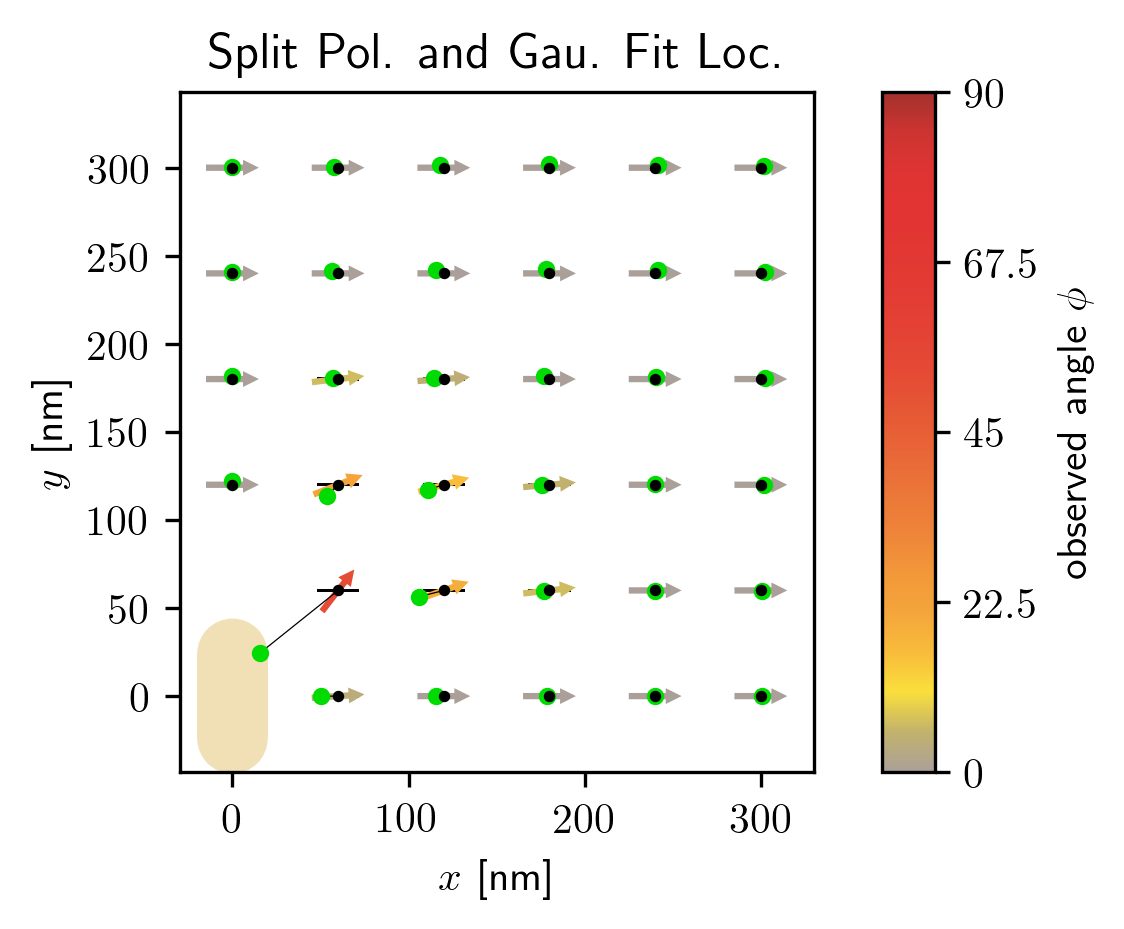

In [56]:
locations_300, angles_300 = fixed_ori_mol_placement(mol_grid_pts_1D=6, x_max=300, y_max=300)
simTestInst_few_mol_h_300 = SimulatedExperiment(locations_300, mol_angle=0)
simTestInst_few_mol_h_300.trial_images = simTestInst_few_mol_h_300.calculate_BEM_fields()

simTestInst_few_mol_h_300.plot_mispol_map_wMisloc()


 initial guess for molecule 0 location: (0.009238515856044873,122.2101142449033)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  0.009238515856044873 
 ini_y,  122.2101142449033 
 self.quel_a,  61.77701186 
 self.quel_c,  25.96014311 

In quenching zone? False

 initial guess for molecule 1 location: (0.003944760328209293,181.8101989001632)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  0.003944760328209293 
 ini_y,  181.8101989001632 
 self.quel_a,  61.77701186 
 self.quel_c,  25.96014311 

In quenching zone? False

 initial guess for molecule 2 location: (-0.001273458000729742,241.0333118183495)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  -0.001273458000729742 
 ini_y,  241.0333118183495 
 self.quel_a,  61.77701186 
 self.quel_c,  25.96014311 

In quenching zone? False

 initial guess for molecule 3 location: (-0.0016737055262746904,300.21860545869254)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x, 

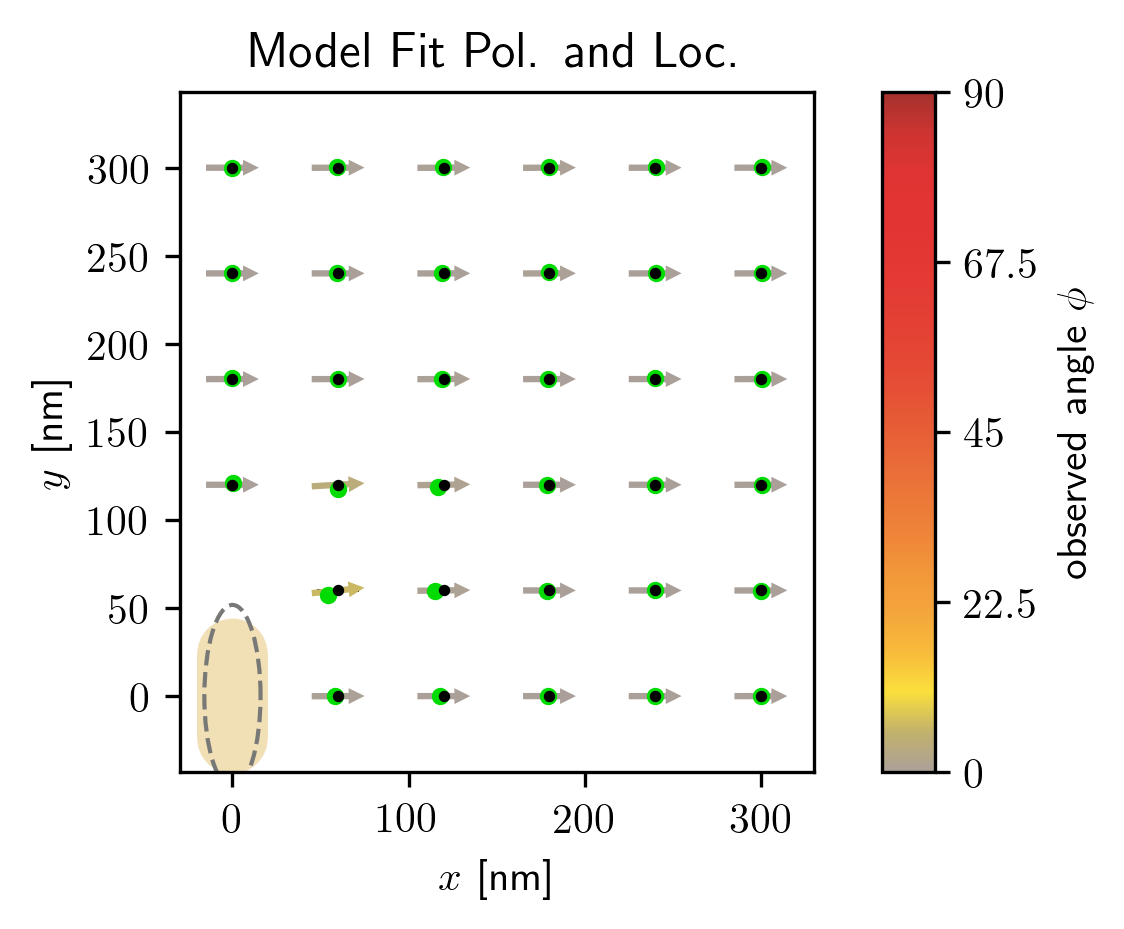

In [57]:
# Model fit
# Gaussian guess, checked

test_BEM_fit_instance_few_mol_h_300 = fit.FitModelToData(
    simTestInst_few_mol_h_300.BEM_images, 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss'
    )
test_BEM_fit_few_mol_h_300 = test_BEM_fit_instance_few_mol_h_300.fit_model_to_image_data(
    check_ini=True)

## Plot fit results
test_BEM_fit_instance_few_mol_h_300.plot_fit_results_as_quiver_map(simTestInst_few_mol_h_300)   

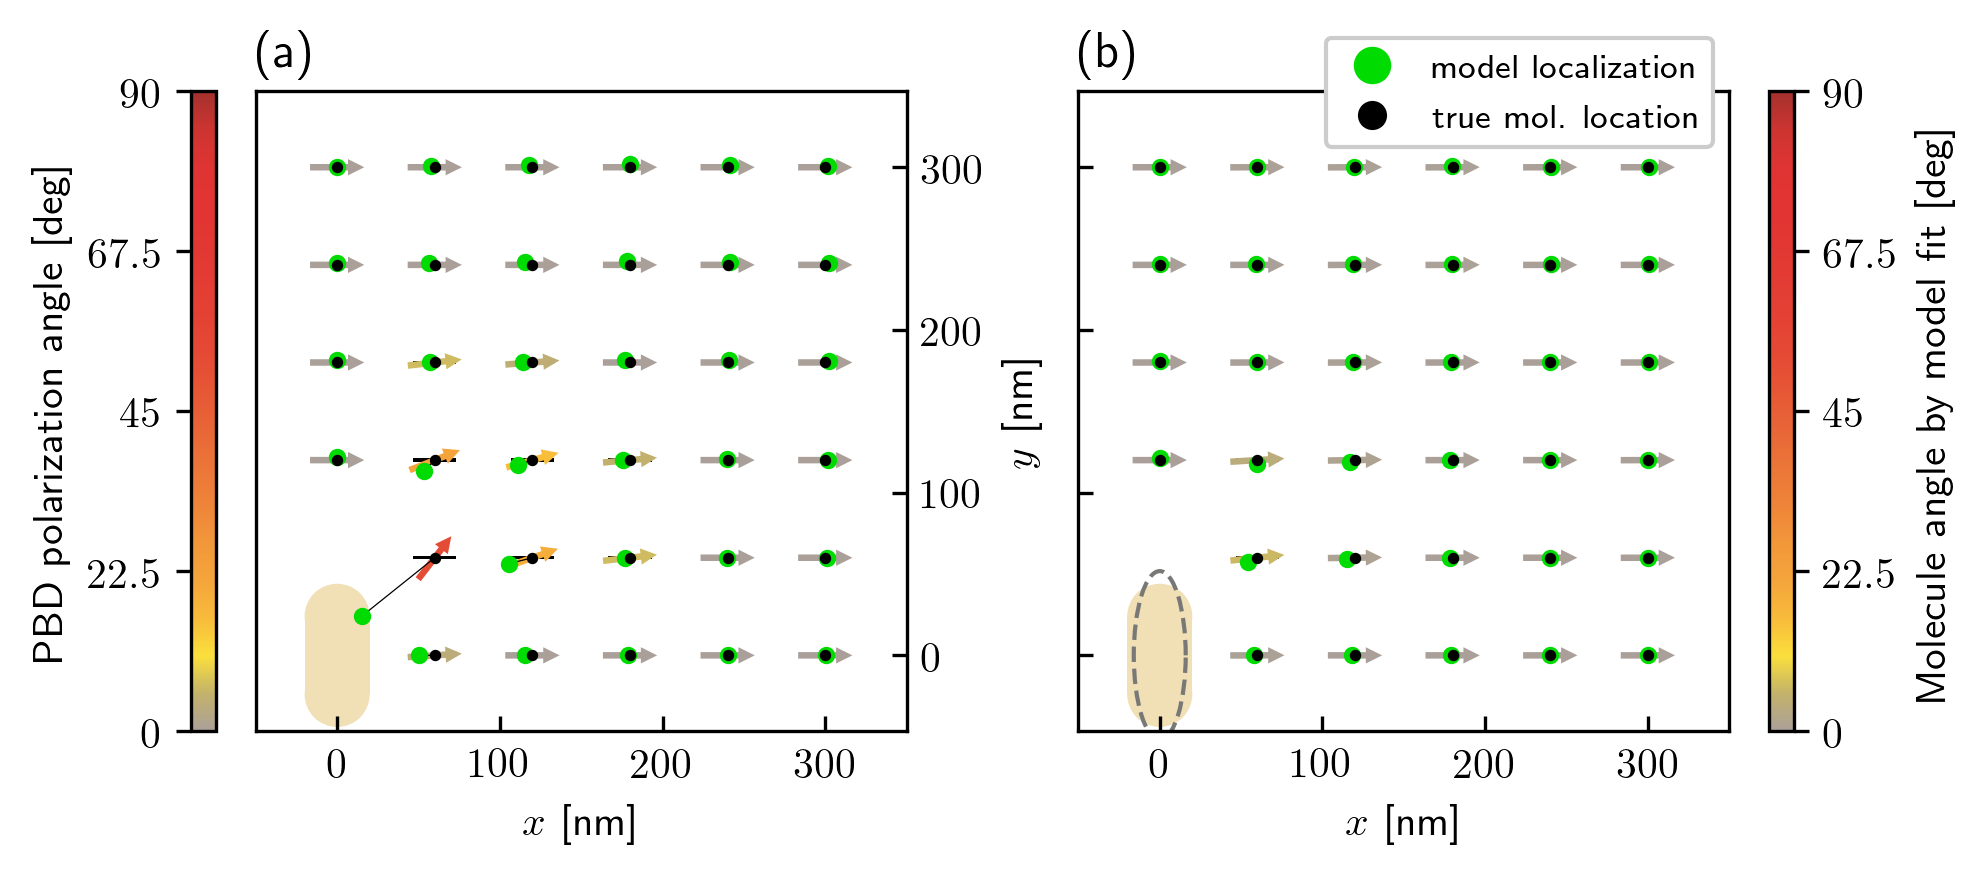

In [62]:
fig5(simTestInst_few_mol_h_300, test_BEM_fit_instance_few_mol_h_300, [-50,350])

### y-oriented equivalent

In [63]:
locations_125, angles_125 = fixed_ori_mol_placement(mol_grid_pts_1D=6, x_max=125, y_max=125)
simTestInst_few_mol_v_125 = SimulatedExperiment(locations_125, mol_angle=np.pi/2)
simTestInst_few_mol_v_125.trial_images = simTestInst_few_mol_v_125.calculate_BEM_fields()

# simTestInst_few_mol_v_125.plot_mispol_map_wMisloc()

# Model fit
# Gaussian guess, checked

test_BEM_fit_instance_few_mol_v_125 = fit.FitModelToData(
    simTestInst_few_mol_v_125.BEM_images, 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss'
    )
test_BEM_fit_few_mol_v_125 = test_BEM_fit_instance_few_mol_v_125.fit_model_to_image_data(
    check_ini=True)

## Plot fit results
# test_BEM_fit_instance_few_mol_v_125.plot_fit_results_as_quiver_map(simTestInst_few_mol_v_125)   

starting Matlab...
given even number of points for Fibonacci lattice, 
  adding 1...
1th molecule
calculating diffracted fields
2th molecule
calculating diffracted fields
3th molecule
calculating diffracted fields
4th molecule
calculating diffracted fields
5th molecule
calculating diffracted fields
6th molecule
calculating diffracted fields
7th molecule
calculating diffracted fields
8th molecule
calculating diffracted fields
9th molecule
calculating diffracted fields
10th molecule
calculating diffracted fields
11th molecule
calculating diffracted fields
12th molecule
calculating diffracted fields
13th molecule
calculating diffracted fields
14th molecule
calculating diffracted fields
15th molecule
calculating diffracted fields
16th molecule
calculating diffracted fields
17th molecule
calculating diffracted fields
18th molecule
calculating diffracted fields
19th molecule
calculating diffracted fields
20th molecule
calculating diffracted fields
21th molecule
calculating diffracted fields


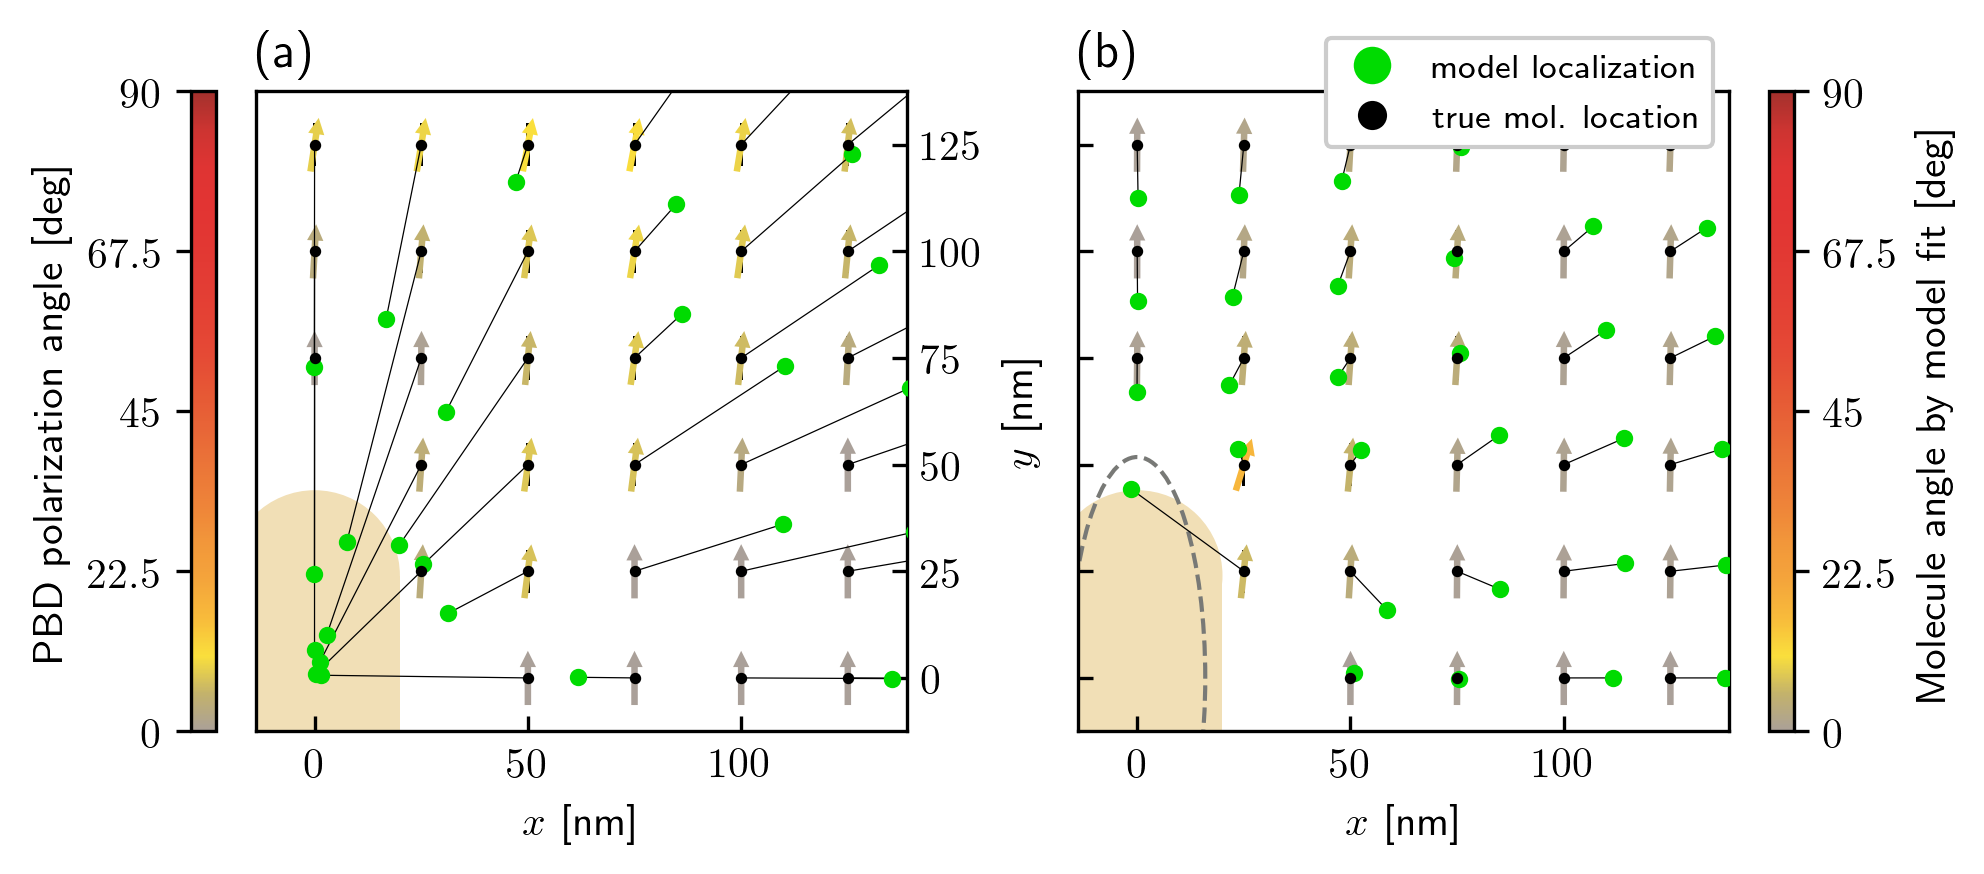

In [65]:
fig5(simTestInst_few_mol_v_125, test_BEM_fit_instance_few_mol_v_125)

#### Owch, that doesn't actually work that well... Let's try larger distances

starting Matlab...
given even number of points for Fibonacci lattice, 
  adding 1...
1th molecule
calculating diffracted fields
2th molecule
calculating diffracted fields
3th molecule
calculating diffracted fields
4th molecule
calculating diffracted fields
5th molecule
calculating diffracted fields
6th molecule
calculating diffracted fields
7th molecule
calculating diffracted fields
8th molecule
calculating diffracted fields
9th molecule
calculating diffracted fields
10th molecule
calculating diffracted fields
11th molecule
calculating diffracted fields
12th molecule
calculating diffracted fields
13th molecule
calculating diffracted fields
14th molecule
calculating diffracted fields
15th molecule
calculating diffracted fields
16th molecule
calculating diffracted fields
17th molecule
calculating diffracted fields
18th molecule
calculating diffracted fields
19th molecule
calculating diffracted fields
20th molecule
calculating diffracted fields
21th molecule
calculating diffracted fields


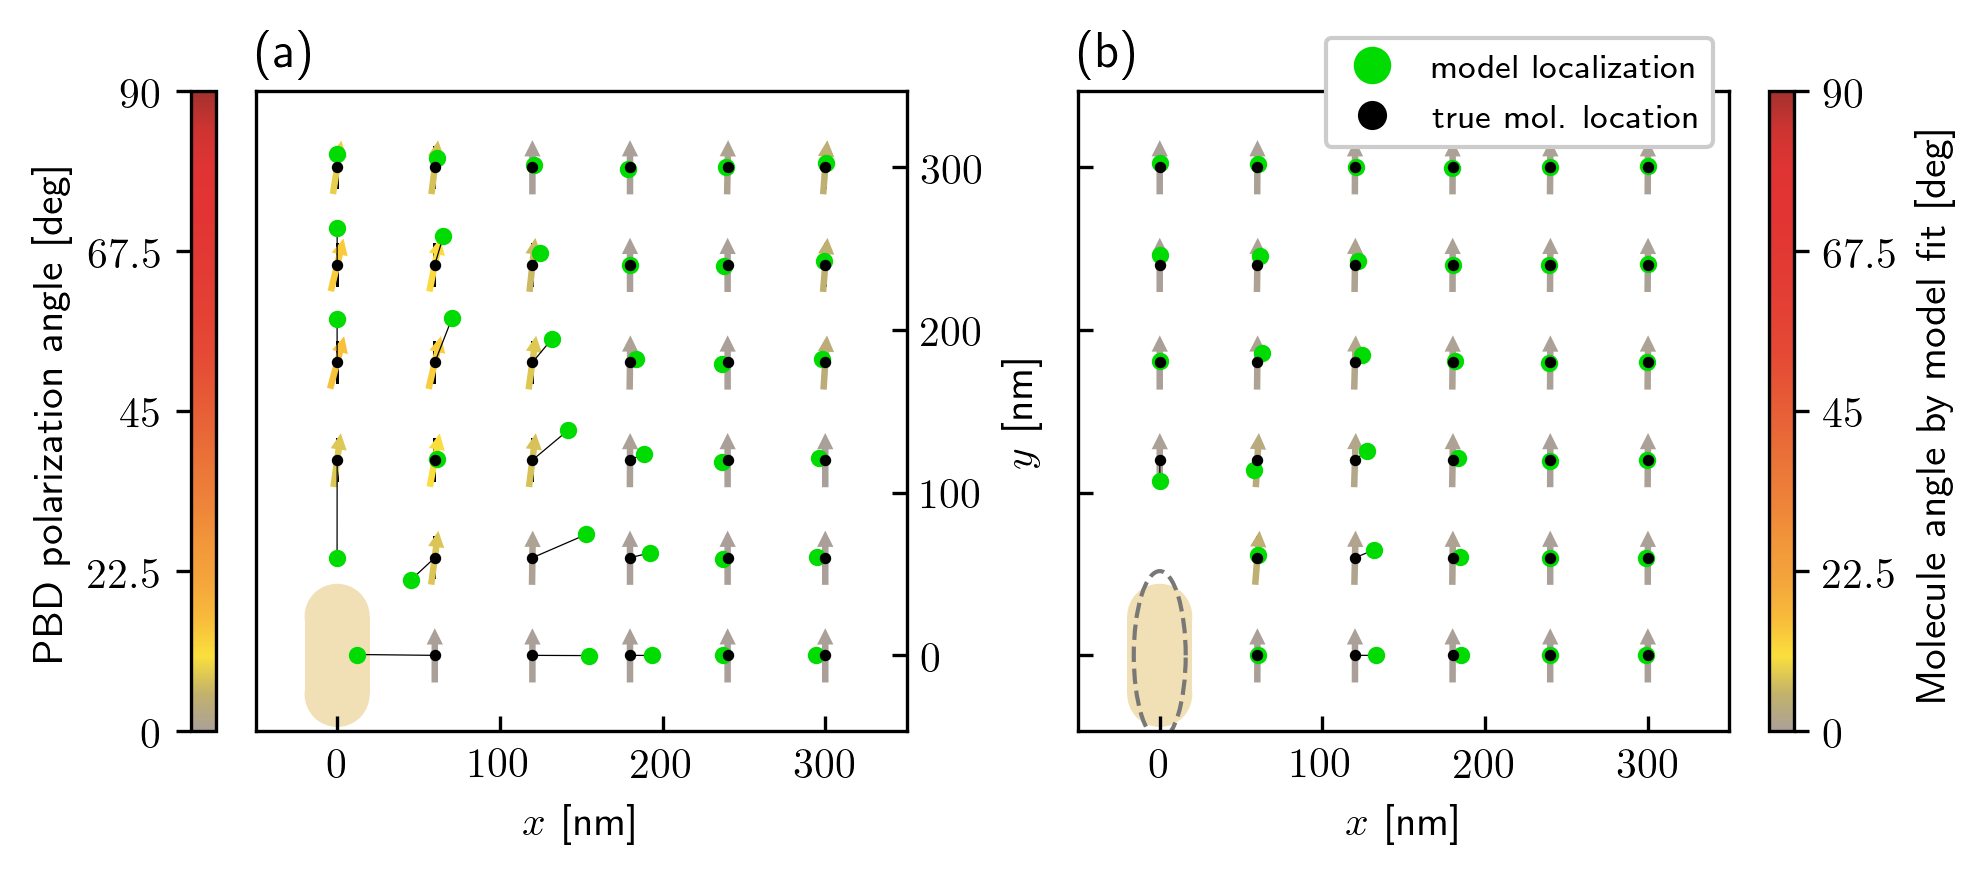

In [66]:
locations_300, angles_300 = fixed_ori_mol_placement(mol_grid_pts_1D=6, x_max=300, y_max=300)
simTestInst_few_mol_v_300 = SimulatedExperiment(locations_300, mol_angle=np.pi/2)
simTestInst_few_mol_v_300.trial_images = simTestInst_few_mol_v_300.calculate_BEM_fields()

# simTestInst_few_mol_v_300.plot_mispol_map_wMisloc()

# Model fit
# Gaussian guess, checked

test_BEM_fit_instance_few_mol_v_300 = fit.FitModelToData(
    simTestInst_few_mol_v_300.BEM_images, 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss'
    )
test_BEM_fit_few_mol_v_300 = test_BEM_fit_instance_few_mol_v_300.fit_model_to_image_data(
    check_ini=True)


## Plot fit results
fig5(simTestInst_few_mol_v_300, test_BEM_fit_instance_few_mol_v_300, [-50,350])


### I want higher res!

starting Matlab...
given even number of points for Fibonacci lattice, 
  adding 1...
1th molecule
calculating diffracted fields
2th molecule
calculating diffracted fields
3th molecule
calculating diffracted fields
4th molecule
calculating diffracted fields
5th molecule
calculating diffracted fields
6th molecule
calculating diffracted fields
7th molecule
calculating diffracted fields
8th molecule
calculating diffracted fields
9th molecule
calculating diffracted fields
10th molecule
calculating diffracted fields
11th molecule
calculating diffracted fields
12th molecule
calculating diffracted fields
13th molecule
calculating diffracted fields
14th molecule
calculating diffracted fields
15th molecule
calculating diffracted fields
16th molecule
calculating diffracted fields
17th molecule
calculating diffracted fields
18th molecule
calculating diffracted fields
19th molecule
calculating diffracted fields
20th molecule
calculating diffracted fields
21th molecule
calculating diffracted fields


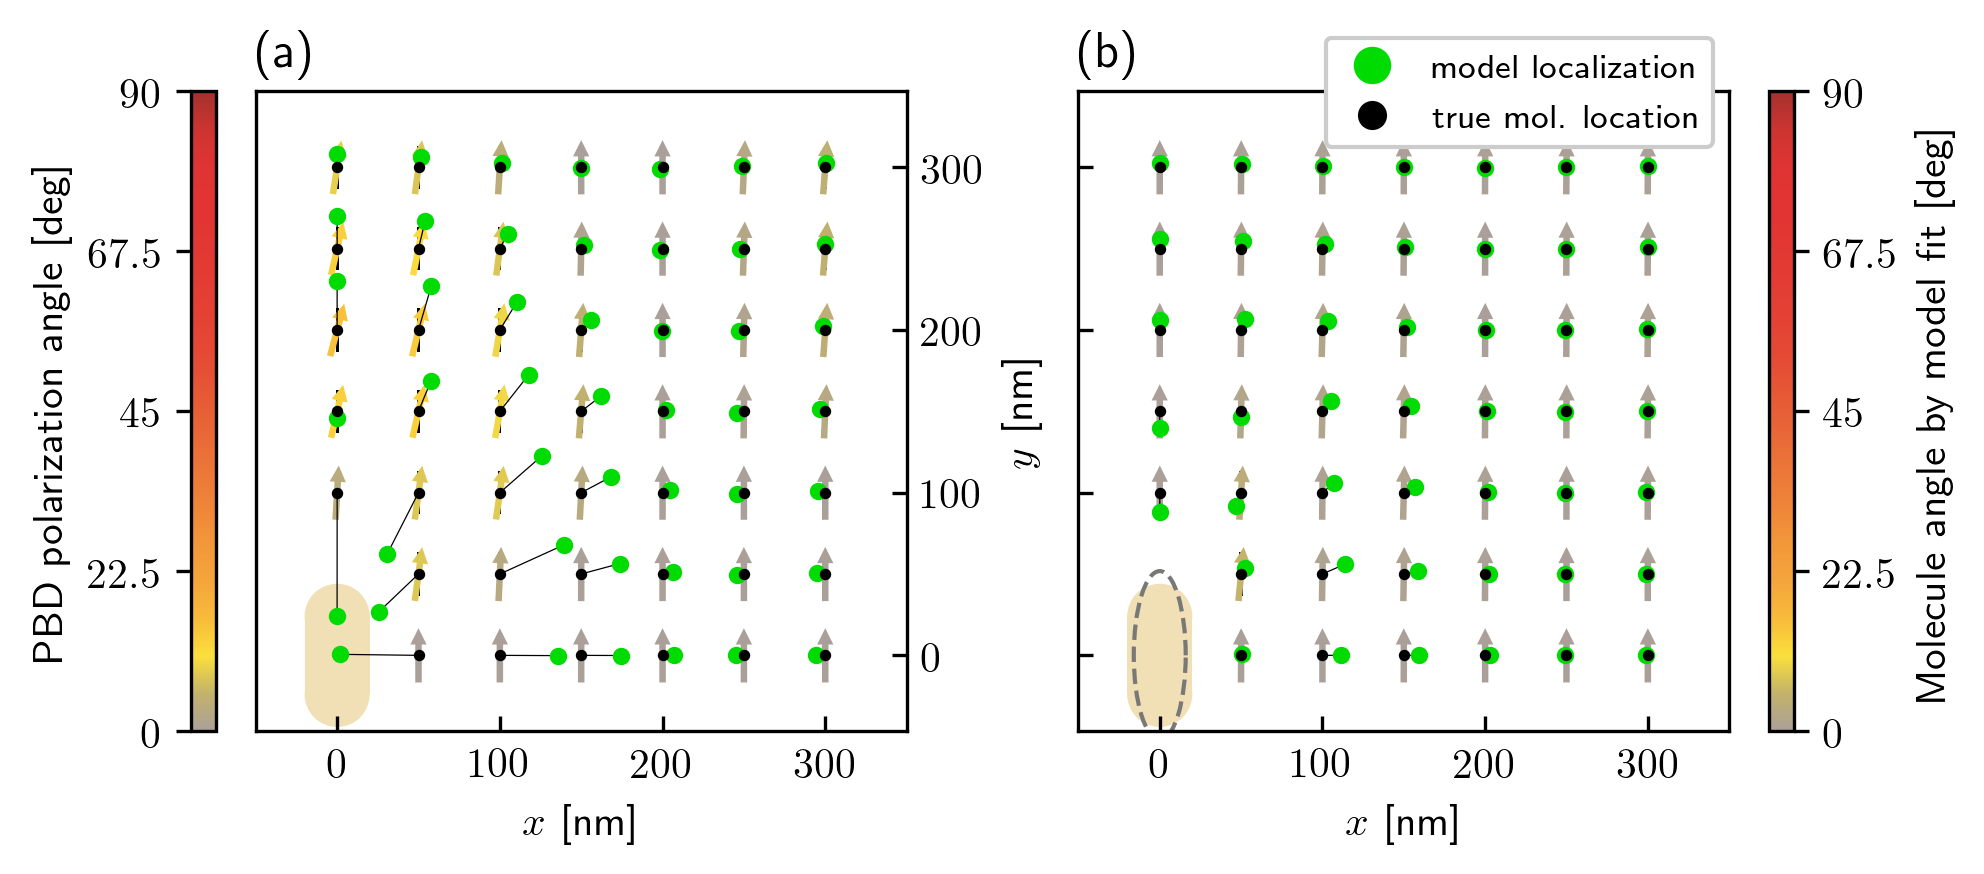

In [67]:
locations_300hires, angles_300hires = fixed_ori_mol_placement(mol_grid_pts_1D=7, x_max=300, y_max=300)
simTestInst_few_mol_v_300hires = SimulatedExperiment(locations_300hires, mol_angle=np.pi/2)
simTestInst_few_mol_v_300hires.trial_images = simTestInst_few_mol_v_300hires.calculate_BEM_fields()

# simTestInst_few_mol_v_300hires.plot_mispol_map_wMisloc()

# Model fit
# Gaussian guess, checked

test_BEM_fit_instance_few_mol_v_300hires = fit.FitModelToData(
    simTestInst_few_mol_v_300hires.BEM_images, 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss'
    )
test_BEM_fit_few_mol_v_300hires = test_BEM_fit_instance_few_mol_v_300hires.fit_model_to_image_data(
    check_ini=True)


## Plot fit results
fig5(simTestInst_few_mol_v_300hires, test_BEM_fit_instance_few_mol_v_300hires, [-50,350])


---

### Older than 03/28/19

In [27]:
# ## Smart guess correction with gaussian inital guess

# test_BEM_fit_instance_few_mol_h_100 = fit.FitModelToData(
#     simTestInst_few_mol_h_100.BEM_images, 
# #     ini_guess=simTestInst_few_mol.mol_locations,
#     ini_guess='gauss',
#     )
# test_BEM_fit_few_mol_h_100 = test_BEM_fit_instance_few_mol_h_100.fit_model_to_image_data(check_ini=True)

# ## Plot fit results
# test_BEM_fit_instance_few_mol_h_100.plot_fit_results_as_quiver_map(simTestInst_few_mol_h_100)   

In [28]:
# ## Initial guess defaults to position of maximum intensity. 

# test_BEM_fit_instance_few_mol_h_100 = fit.FitModelToData(
#     simTestInst_few_mol_h_100.BEM_images, 
#     ini_guess=simTestInst_few_mol.mol_locations
#     )
# test_BEM_fit_few_mol_h_100 = test_BEM_fit_instance_few_mol_h_100.fit_model_to_image_data()

# ## Plot fit results
# test_BEM_fit_instance_few_mol_h_100.plot_fit_results_as_quiver_map(simTestInst_few_mol_h_100)   

# Old stuff (as of 02/25/19)

Let's look at molecule index 9 and see it the model image looks like the data

In [29]:
# test_BEM_fit_few_mol[9]

In [30]:
# test_BEM_fit_instance_few_mol.plot_image_from_params(test_BEM_fit_few_mol[9])
# ax = plt.gca()
# ax.set(xlim=[0,500], ylim=[0,500],
#       title='Model Image from fit params for molecule "9"')

# test_BEM_fit_instance_few_mol.plot_raveled_image(simTestInst_few_mol.BEM_images[9])
# ax = plt.gca()
# ax.set(xlim=[0,500], ylim=[0,500],
#       title='BEM Image from fit params for molecule "9"')

In [31]:

# test_BEM_fit_instance_few_mol.plot_raveled_image(simTestInst_few_mol.BEM_images[9])

# ax = plt.gca()


# test_BEM_fit_instance_few_mol.plot_image_from_params(test_BEM_fit_few_mol[9], ax=ax)

# ax.set(xlim=[0,500], ylim=[0,500],
#       title='Model Image from fit params for molecule "9"')

# # ax = plt.gca()
# # ax.set(xlim=[0,500], ylim=[0,500],
# #       title='BEM Image from fit params for molecule "9"')

# beyond this is older than 02/13/19

In [32]:
# locations, angles = fixed_ori_mol_placement(mol_grid_pts_1D=7, x_max=300, y_max=300)
# simTestInst_few_more_mol = SimulatedExperiment(locations, mol_angle=np.pi/2)
# simTestInst_few_more_mol.trial_images = simTestInst_few_more_mol.calculate_BEM_fields()

In [33]:
# simTestInst_few_more_mol.plot_mispol_map_wMisloc()

In [34]:
# test_BEM_fit_instance_few_more_mol = fit.FitModelToData(simTestInst_few_more_mol.BEM_images)
# test_BEM_fit_few_more_mol = test_BEM_fit_instance_few_more_mol.fit_model_to_image_data()
# test_BEM_fit_instance_few_more_mol.plot_fit_results_as_quiver_map(simTestInst_few_more_mol)   

In [35]:
# test_BEM_fit_instance.model_fit_results

In [36]:
# test_BEM_fit_instance.model_fit_results = test_BEM_fit_instance.model_fit_results*np.array([[1,-1,1]])

In [37]:
# test_BEM_fit_instance.plot_fit_results_as_quiver_map(simTestInst)  

In [38]:
# simTestInst_yMol = SimulatedExperiment(locations, mol_angle=0)
# simTestInst_yMol.plot_mispol_map_wMisloc()

# test_BEM_fit_instance_yMol = fit.FitModelToData(simTestInst_yMol.BEM_images)
# test_BEM_fit_yMol = test_BEM_fit_instance_yMol.fit_model_to_image_data()
# # test_BEM_fit_instance.plot_contour_fit_over_data(0)

# # test_BEM_fit_instance_yMol.model_fit_results = test_BEM_fit_instance_yMol.model_fit_results*np.array([[1,-1,1]])
# test_BEM_fit_instance_yMol.plot_fit_results_as_quiver_map(simTestInst_yMol)

Seems to be working now, but not much better than the gaussian fits at this point. Arguably worse locatization, polarization seems significantly better but that could be due to the correct initial guess. 

## Time to try and fit Curly's images. Should be able to feed the data into 'FitModelToData' after first loading the data in from the matlab files.

In [39]:
# import scipy.io as sio

In [40]:
# mol_img_y_700_file = sio.loadmat('/Users/chair/Documents/Academia/SuperRes/Biteen_colab/from_Biteen_group/Curly_simulated_images_nrod_mol_downloaded_010818/mol_img_y_700.mat')

In [41]:
# mol_img_y_700 = mol_img_y_700_file['mol_img_y_700']

In [42]:
# mol_img_y_700.shape

In [43]:
# simTestInst_yMol.BEM_images.shape

Need to reshape Curly's data to match the BEM_images shape I have been using. 

In [44]:
# reshaped_Curly_image_y_700nm = mol_img_y_700.reshape((99, 300*300))

In [45]:
# reshaped_Curly_image_y_700nm.shape

need to load in Curly's x and y coordinates and modify the 'FitModelToData' to accept coordinates different from 'eye' default. But first, lunch.

In [46]:
# x_image_file = sio.loadmat('/Users/chair/Documents/Academia/SuperRes/Biteen_colab/from_Biteen_group/Curly_simulated_images_nrod_mol_downloaded_010818/x_image.mat')
# y_image_file = sio.loadmat('/Users/chair/Documents/Academia/SuperRes/Biteen_colab/from_Biteen_group/Curly_simulated_images_nrod_mol_downloaded_010818/y_image.mat')
# true_position_file = sio.loadmat('/Users/chair/Documents/Academia/SuperRes/Biteen_colab/from_Biteen_group/Curly_simulated_images_nrod_mol_downloaded_010818/true_position.mat')

In [47]:
# curly_x_space = x_image_file['x_image'][:, 0]
# curly_y_space = y_image_file['y_image'][:, 0]

In [48]:
# true_position_file['true_pos'].shape

In [49]:
# Curly_true_position = np.hstack((true_position_file['true_pos'], np.zeros((99,1))))

In [50]:
# class FitModelToCurlyData(fit.FitModelToData):
#     """Should do the same thing as FitModelToData Except handle 
#         Curly's grid of observation points 
    
#     Args:
#         image_data: same as super
#         obs_coords: Meshgrid of Curly's points
        
#     Attributes:
#         default_plot_limits:
#         mol_locations:
#         mol_angles:
#         rod_angle:
        
#     """
#     pass

Really I should build an Exp class for Curly's stuff, so the true positions are accessable to plotting functions

I can actually do this with 'Simulation'

In [51]:
# class SimulatedCurlyExperiment():
    

In [52]:
# Curly_X, Curly_Y = np.meshgrid(curly_x_space, curly_y_space)
# Curly_Simultation = SimulatedExperiment(locations=Curly_true_position,x_obv_grid=Curly_X, y_obv_grid=Curly_Y)


need a new class that doesnt automatically run BEM calculations. JK just commented out the line in Simulation.\__init\__ that ran the BEM calculations and stored the results as self.BEM_images

In [53]:
# class FitModelToAnyData(fit.FitModelToData):
    
#     def __init__(self, image_data, 
#                  x_obv_grid=eye[1],
#                  y_obv_grid=eye[2]):
        
#         self.mol_angle=0 
#         self.rod_angle=np.pi/2

#         self.x_obv_grid=x_obv_grid
#         self.y_obv_grid=y_obv_grid
        
#         self.image_data = image_data

In [54]:
# Fit_Curly_images = FitModelToAnyData(reshaped_Curly_image_y_700nm, Curly_X, Curly_Y)

In [55]:
# Fit_Curly_images.plot_fit_results_as_quiver_map(Curly_Simultation)